In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

In [20]:
# Cargar el dataset
data = pd.read_csv('electricity-consumption-processed.csv', sep=';', parse_dates=['datetime'])
data.set_index('datetime', inplace=True)

# Verificar los datos
print(data.head())

                    substation feeder  consumption
datetime                                          
2017-01-01 00:00:00          A     A1    64.671363
2017-01-01 01:00:00          A     A1    58.000000
2017-01-01 02:00:00          A     A1    58.000000
2017-01-01 03:00:00          A     A1    58.000000
2017-01-01 04:00:00          A     A1    52.000000


In [21]:
# Filtrar datos por subestación y alimentador, si es necesario
substation = 'A'  # Cambia según tu dataset
feeder = 'A1'      # Cambia según tu dataset
data_filtered = data[(data['substation'] == substation) & (data['feeder'] == feeder)]
print(data_filtered)

                    substation feeder  consumption
datetime                                          
2017-01-01 00:00:00          A     A1    64.671363
2017-01-01 01:00:00          A     A1    58.000000
2017-01-01 02:00:00          A     A1    58.000000
2017-01-01 03:00:00          A     A1    58.000000
2017-01-01 04:00:00          A     A1    52.000000
...                        ...    ...          ...
2020-12-31 19:00:00          A     A1          NaN
2020-12-31 20:00:00          A     A1          NaN
2020-12-31 21:00:00          A     A1          NaN
2020-12-31 22:00:00          A     A1          NaN
2020-12-31 23:00:00          A     A1          NaN

[35064 rows x 3 columns]


In [22]:
# Definir el mes específico que quieres filtrar
start_date = '2019-01-01'
end_date = '2020-12-31'

# Filtrar los datos históricos y las predicciones para ese mes
data_filtered= data_filtered[start_date:end_date]


In [23]:
# Agrupar por día y calcular el consumo máximo
daily_max_consumption = data_filtered.groupby(data_filtered.index.date)['consumption'].max().reset_index()
daily_max_consumption.columns = ['date', 'max_consumption']
daily_max_consumption.set_index('date', inplace=True)


In [24]:
# Filtrar para quedarte solo con los consumos máximos por día
daily_max_consumption = daily_max_consumption[daily_max_consumption['max_consumption'].notna()]
# Establecer la frecuencia del índice a diaria
daily_max_consumption = daily_max_consumption.asfreq('D')
daily_max_consumption=daily_max_consumption.dropna()

In [25]:
# Función objetivo para Optuna
def objective(trial):
    p = trial.suggest_int("p", 0, 10)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 0, 10)

    try:
        # Ajustar el modelo ARIMA
        model = ARIMA(daily_max_consumption['max_consumption'], order=(p, d, q))
        results = model.fit()

        # Realizar predicciones dentro del conjunto de datos
        pred = results.get_prediction(start=daily_max_consumption.index[0], end=daily_max_consumption.index[-1])
        pred_mean = pred.predicted_mean

        # Calcular el error cuadrático medio
        mse = mean_squared_error(daily_max_consumption['max_consumption'], pred_mean)
        return mse
    except Exception:
        return float('inf')  # Penalizar combinaciones que no funcionen


In [26]:
# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Número de pruebas

# Resultados de la optimización
print("Mejores parámetros:", study.best_params)
print("Mejor MSE:", study.best_value)

[I 2024-11-19 12:03:43,073] A new study created in memory with name: no-name-514820fc-ad2e-4129-8ac2-bd9576adf9b7
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarni

Mejores parámetros: {'p': 8, 'd': 0, 'q': 10}
Mejor MSE: 76.45286741105703


In [27]:
# Usar los mejores parámetros para ajustar el modelo final
best_params = study.best_params
model = ARIMA(daily_max_consumption['max_consumption'], 
              order=(best_params['p'], best_params['d'], best_params['q']))
results = model.fit()

C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

In [28]:
# Predicciones
forecast = results.get_prediction(start=daily_max_consumption.index[0], end=daily_max_consumption.index[-1])
pred_mean = forecast.predicted_mean

In [29]:
# Calcular métricas finales
mae = mean_absolute_error(daily_max_consumption['max_consumption'], pred_mean)
rmse = np.sqrt(mean_squared_error(daily_max_consumption['max_consumption'], pred_mean))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 6.48, RMSE: 8.74


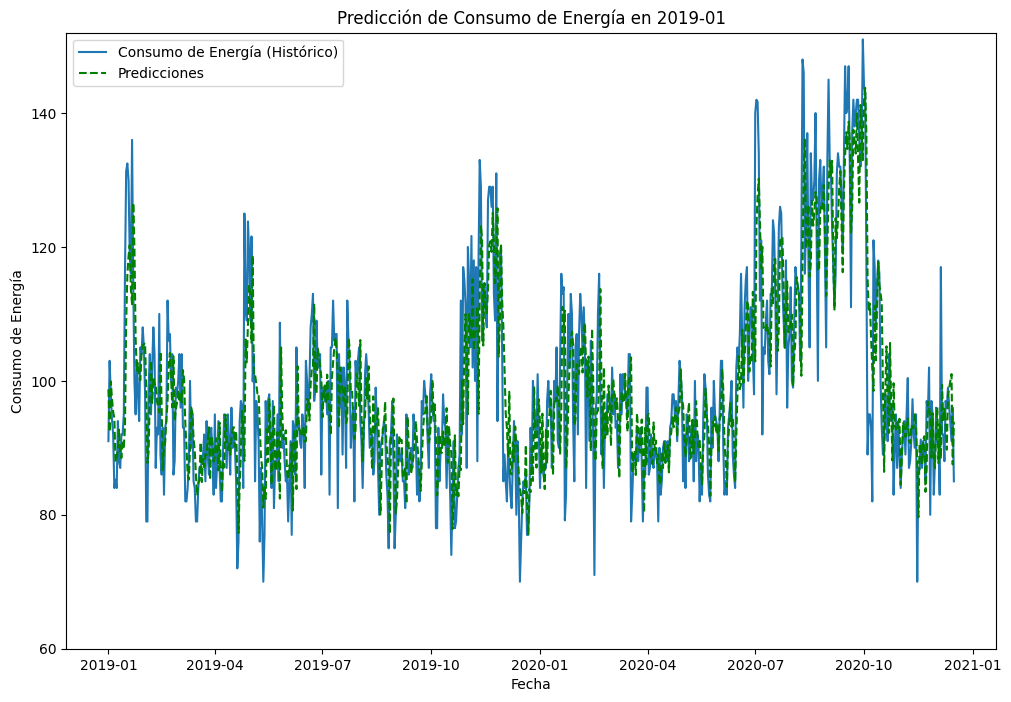

In [30]:

# Graficar
plt.figure(figsize=(12, 8))
plt.plot(daily_max_consumption, label='Consumo de Energía (Histórico)')
plt.plot(pred_mean, color='green', linestyle='--', label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.title(f'Predicción de Consumo de Energía en {start_date[:7]}')
plt.ylim(60, 152)
plt.legend()
plt.show()